## DenseNET121

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os,shutil

# Fastai reloads
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Impost fastai
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from fastai.callbacks import *
from fastai.imports import *
from fastai.callbacks.mem import PeakMemMetric

from pathlib import Path

from torchvision.models import *
from torch.nn import CrossEntropyLoss
import cv2
#import pretrainedmodels

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns

In [3]:
PATH=Path('data/')

## Create Data block (Try with half size)

In [4]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [5]:
img=open_image(PATH/'train_resized'/os.listdir(PATH/'train_resized')[1])

In [6]:
img.shape

torch.Size([3, 150, 210])

In [7]:
src_size=np.array(img.shape[1:]);src_size

array([150, 210])

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [9]:
data = (src.transform(tfms, size=src_size//2)
        .databunch(bs=256).normalize(imagenet_stats))

In [10]:
data.classes

['1', '2', '3', '4', '5']

In [36]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

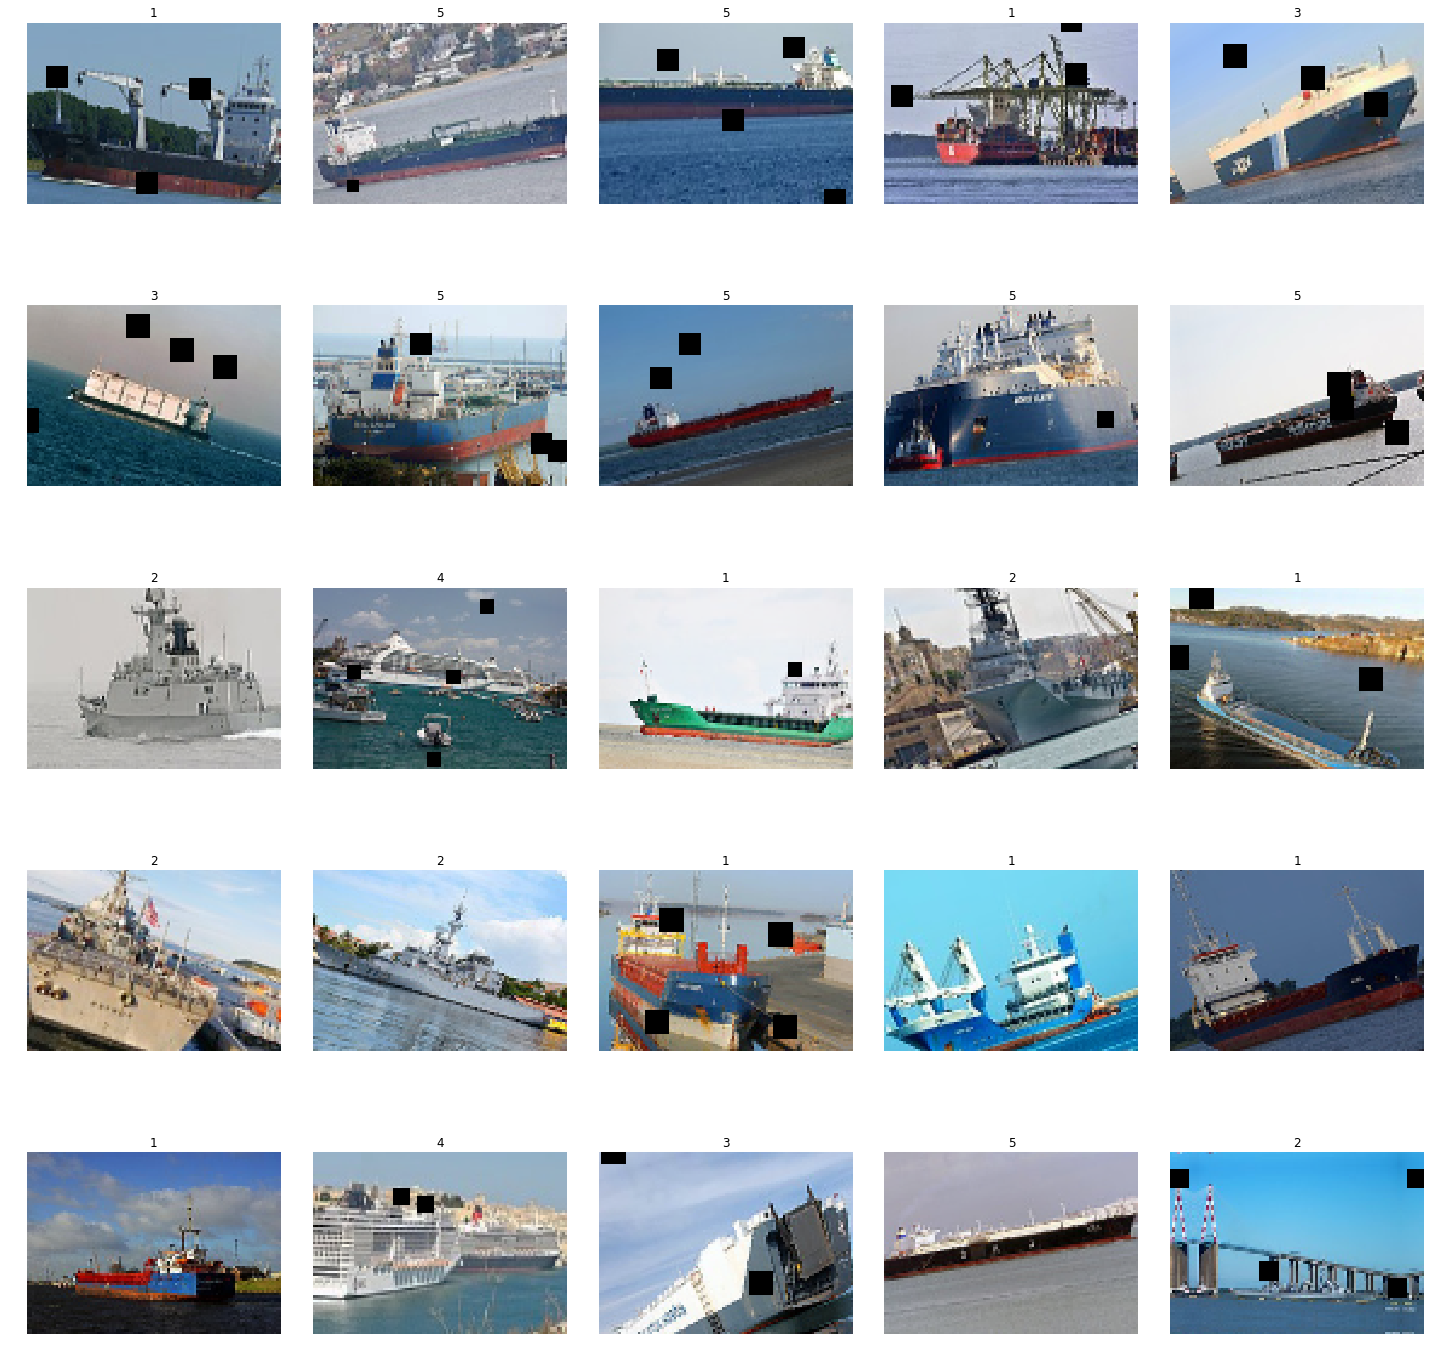

In [37]:
data.show_batch()

## Try with DenseNEt121

In [11]:
metrics_custom=[fbeta,accuracy_thresh]

In [12]:
learn=cnn_learner(data,models.densenet121,metrics=metrics_custom)

In [32]:
stage1_dense121_call_back=[CSVLogger(learn=learn, filename='dense121-stage1-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=3),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='dense121_best_stage-1-aug'),
                          PeakMemMetric(learn)]

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


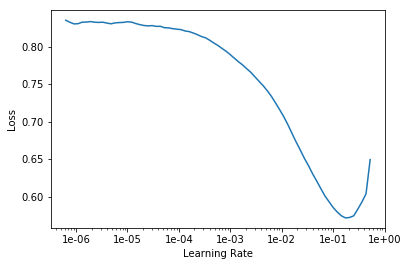

In [34]:
learn.recorder.plot()

In [35]:
lr=3e-2

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.615451,0.425360,0.629168,0.845920,0,0,54,5702,00:07
1,0.439232,0.291270,0.713257,0.872320,0,0,0,5452,00:05
2,0.340552,0.233626,0.801295,0.897120,0,0,0,5452,00:06
3,0.276418,0.230561,0.813295,0.900160,0,0,0,5452,00:05
4,0.232611,0.148230,0.890605,0.938400,0,0,0,5452,00:05
5,0.199764,0.159100,0.876381,0.937920,0,0,0,5452,00:05
6,0.174753,0.134236,0.900076,0.948000,0,0,0,5452,00:05
7,0.153676,0.121497,0.901371,0.952480,0,0,0,5452,00:05
8,0.135687,0.131631,0.902571,0.948320,0,0,0,5452,00:05
9,0.122942,0.160366,0.883829,0.941120,0,0,0,5452,00:05


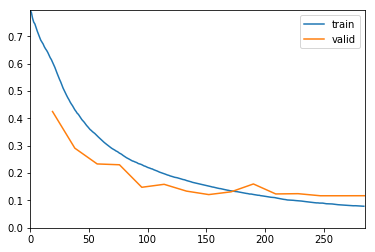

Better model found at epoch 0 with fbeta value: 0.6291682720184326.
Better model found at epoch 1 with fbeta value: 0.7132571935653687.
Better model found at epoch 2 with fbeta value: 0.801295280456543.
Better model found at epoch 3 with fbeta value: 0.813295304775238.
Better model found at epoch 4 with fbeta value: 0.8906047940254211.
Better model found at epoch 6 with fbeta value: 0.900076150894165.
Better model found at epoch 7 with fbeta value: 0.9013714790344238.
Better model found at epoch 8 with fbeta value: 0.9025714993476868.
Better model found at epoch 10 with fbeta value: 0.9137715101242065.
Better model found at epoch 11 with fbeta value: 0.9160380959510803.
Better model found at epoch 12 with fbeta value: 0.9227809309959412.


In [36]:
learn.fit_one_cycle(15,slice(lr),callbacks=stage1_dense121_call_back)

In [37]:
learn.unfreeze()

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


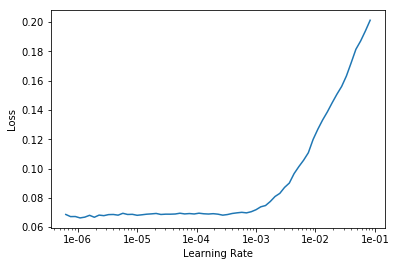

In [39]:
learn.recorder.plot()

In [40]:
#learn.load('dense121_best_stage-1-aug')

In [41]:
lr=3e-5

In [42]:
stage2_dense121_call_back=[CSVLogger(learn=learn, filename='dense121-stage2-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=5),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='dense121_best_stage-2-aug'),
                          PeakMemMetric(learn)]

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.076220,0.124249,0.909905,0.953280,0,0,936,4540,00:06
1,0.079153,0.157553,0.896686,0.945920,0,0,22,5406,00:06
2,0.093649,0.220212,0.875867,0.942080,0,0,0,5428,00:06
3,0.099034,0.195530,0.882524,0.942560,0,0,0,5428,00:06
4,0.095609,0.168257,0.879143,0.939840,0,0,0,5428,00:06
5,0.084172,0.132733,0.913276,0.955040,0,0,0,5428,00:06
6,0.077567,0.116611,0.913505,0.960000,0,0,0,5428,00:06
7,0.066716,0.112668,0.923772,0.963520,0,0,0,5428,00:06
8,0.058154,0.111303,0.923638,0.962080,0,0,0,5428,00:06
9,0.050339,0.112072,0.923772,0.963520,0,0,0,5428,00:06


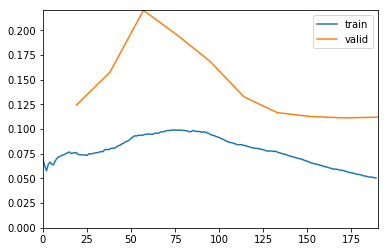

Better model found at epoch 0 with fbeta value: 0.9099047780036926.
Better model found at epoch 5 with fbeta value: 0.9132762551307678.
Better model found at epoch 6 with fbeta value: 0.9135047793388367.
Better model found at epoch 7 with fbeta value: 0.9237715005874634.


In [43]:
learn.fit_one_cycle(10,slice(lr,3e-2),callbacks=stage2_dense121_call_back)

## Pass full size image

In [13]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [14]:
learn=learn.load('dense121_best_stage-2-aug')

In [60]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 105]        9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 75, 105]        128        True      
______________________________________________________________________
ReLU                 [64, 75, 105]        0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 53]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 38, 53]         128        True      
______________________________________________________________________
ReLU                 [64, 38, 53]         0          False     
______________________________________________________________________
Conv2d               [128, 38, 53]        8,192      True      
______________________________________________________________

In [15]:
learn.freeze()

In [62]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 105]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 105]        128        True      
______________________________________________________________________
ReLU                 [64, 75, 105]        0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 53]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 38, 53]         128        True      
______________________________________________________________________
ReLU                 [64, 38, 53]         0          False     
______________________________________________________________________
Conv2d               [128, 38, 53]        8,192      False     
______________________________________________________________

In [17]:
learn.data=data

In [18]:
learn.data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [65]:
learn.metrics

[<function fastai.metrics.fbeta(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-09, sigmoid:bool=True) -> <function NewType.<locals>.new_type at 0x7facda290ea0>>,
 <function fastai.metrics.accuracy_thresh(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.5, sigmoid:bool=True) -> <function NewType.<locals>.new_type at 0x7facda290ea0>>]

In [49]:
stage3_dense121_call_back=[CSVLogger(learn=learn, filename='dense121-stage3-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=5),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='dense121_best_stage-3-aug'),
                          PeakMemMetric(learn)]

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


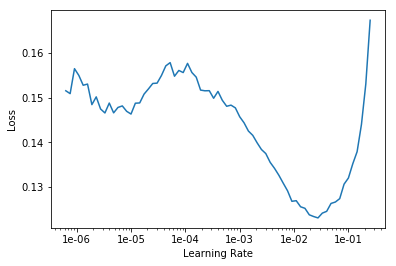

In [51]:
learn.recorder.plot()

In [52]:
lr=4e-3

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.142055,0.153272,0.896171,0.949600,0,0,100,11524,00:13
1,0.117414,0.122543,0.909105,0.956800,0,0,0,11100,00:12
2,0.099036,0.103202,0.923676,0.960480,0,0,0,11100,00:12
3,0.081750,0.103012,0.924609,0.961120,0,0,0,11100,00:12
4,0.070523,0.102947,0.928076,0.961600,0,0,0,11100,00:12
5,0.059001,0.094698,0.931200,0.967360,0,0,0,11100,00:12
6,0.054422,0.089833,0.936705,0.968800,0,0,0,11100,00:12
7,0.047893,0.103975,0.932210,0.964960,0,0,0,11100,00:12
8,0.041824,0.099031,0.936133,0.968000,0,0,0,11100,00:12
9,0.037046,0.097228,0.941105,0.968960,0,0,0,11100,00:12


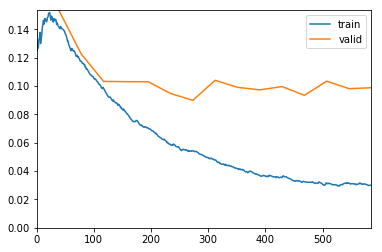

Better model found at epoch 0 with fbeta value: 0.8961713910102844.
Better model found at epoch 1 with fbeta value: 0.9091047644615173.
Better model found at epoch 2 with fbeta value: 0.9236762523651123.
Better model found at epoch 3 with fbeta value: 0.9246094822883606.
Better model found at epoch 4 with fbeta value: 0.9280761480331421.
Better model found at epoch 5 with fbeta value: 0.9312000870704651.
Better model found at epoch 6 with fbeta value: 0.9367048144340515.
Better model found at epoch 9 with fbeta value: 0.9411047697067261.


In [53]:
learn.fit_one_cycle(15,slice(lr),callbacks=stage3_dense121_call_back,wd=1e-5)

In [19]:
learn.load('dense121_best_stage-3-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1)

In [20]:
learn.unfreeze()

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


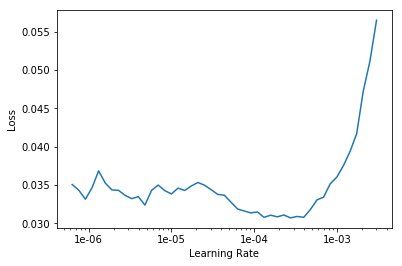

In [57]:
learn.recorder.plot()

In [21]:
lr=4e-5

In [22]:
stage4_dense121_call_back=[CSVLogger(learn=learn, filename='dense121-stage4-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=5),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='dense121_best_stage-4-aug'),
                          PeakMemMetric(learn)]

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.032439,0.090226,0.940305,0.972000,0,0,862,11312,00:19
1,0.032236,0.126222,0.928571,0.964480,0,0,0,10878,00:15
2,0.035353,0.118275,0.924000,0.962720,0,0,0,10878,00:15
3,0.039988,0.122665,0.925448,0.962240,0,0,0,10878,00:15
4,0.039201,0.089347,0.939543,0.968960,0,0,0,10878,00:15
5,0.034511,0.125107,0.924800,0.965600,0,0,0,10878,00:15


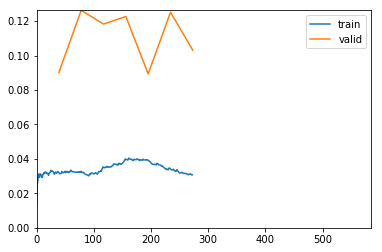

Better model found at epoch 0 with fbeta value: 0.9403047561645508.
Epoch 6: early stopping


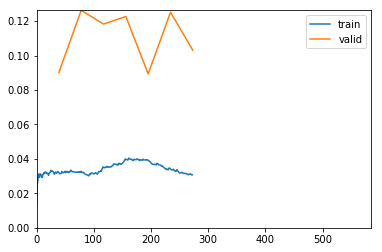

In [23]:
learn.fit_one_cycle(15,slice(lr,4e-3),callbacks=stage4_dense121_call_back,wd=1e-5)

In [24]:
learn.load('dense121_best_stage-3-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1)

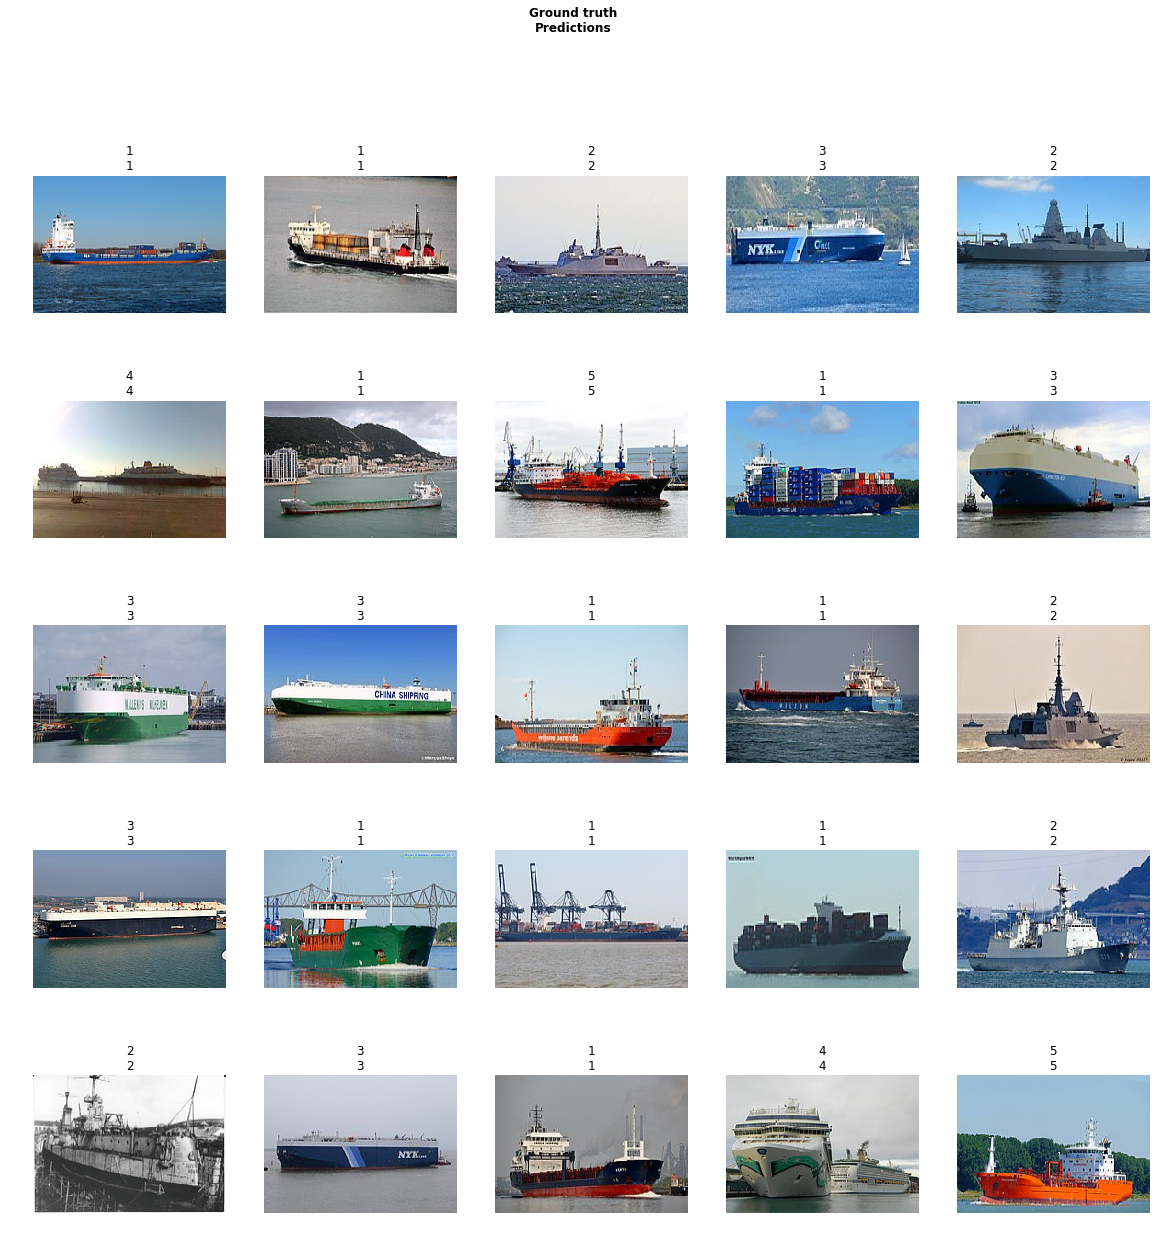

In [139]:
learn.show_results(3)

In [140]:
interp=ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

In [145]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [147]:
losses,idxs = interp.top_losses()

In [148]:
len(data.valid_ds)==len(losses)==len(idxs)

False

In [153]:
pred_v,y,losses=learn.TTA(ds_type=DatasetType.Valid,with_loss=True)

In [25]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [26]:
test_pred_tta

(tensor([[9.9942e-01, 8.3814e-06, 1.0438e-05, 7.7067e-04, 1.2631e-05],
         [6.6697e-05, 4.1757e-04, 9.9958e-01, 2.1798e-04, 1.6123e-04],
         [6.7560e-01, 1.0721e-01, 1.1374e-02, 1.6109e-01, 4.5651e-02],
         ...,
         [3.9767e-02, 7.2566e-04, 9.5002e-01, 6.9428e-03, 1.0419e-02],
         [1.0241e-03, 9.9953e-01, 3.5531e-05, 6.1648e-05, 1.3472e-04],
         [9.8652e-01, 4.8495e-04, 4.2036e-04, 1.9688e-04, 1.5284e-02]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [27]:
preds = np.argmax(test_pred_tta[0], 1)
preds

tensor([0, 2, 0,  ..., 2, 1, 0])

In [28]:
a=array(preds)

In [29]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [30]:
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.head(10)

,image,category
0,2904735.jpg,1
1,2890616.jpg,3
2,2902677.jpg,1
3,2741468.jpg,4
4,2802610.jpg,5
5,1630950.jpg,4
6,2882184.jpg,3
7,2787793.jpg,2
8,2866032.jpg,1
9,2369442.jpg,2


In [171]:
len(submission)

2680

In [31]:
submission.to_csv(PATH/'submission_densenet121.csv',index=False)